In [1]:
import numpy as np # to handle matrix and data operation


import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data
from torch.utils.data import random_split
from torch.utils.data import DataLoader

from torchvision.utils import save_image

from torch.autograd import Variable

from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
import torchvision

import PIL.Image as Image
import io
import matplotlib.pyplot as plt

import shutil

# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#shutil.copyfile("/content/drive/MyDrive/animals_cnn_model/animals-resnet34-29.pth", "./animals-resnet34-29.pth")

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
class SpearmanCorrelation(nn.Module):
    def __init__(self):
        super(SpearmanCorrelation, self).__init__()

    def forward(self, x, y):
        x = torch.flatten(x)
        y = torch.flatten(y)
        x_mean = torch.mean(x)
        y_mean = torch.mean(y)
        x_std = torch.std(x)
        y_std = torch.std(y)
        x = (x - x_mean) / x_std
        y = (y - y_mean) / y_std
        rho = torch.sum(x * y) / (torch.sqrt(torch.sum(x ** 2)) * torch.sqrt(torch.sum(y ** 2)))
        return rho

In [5]:
class SimpleGradient:
    def __init__(self, model, img_size=(28,28), device = 'cpu'):
        self.device = device
        self.model = model
        self.img_size = img_size

    def explain(self, x, y, model = None):
        if model is None:
            model = self.model

        img = x

        if(len(img.size()) <= 3):
            img = img.unsqueeze(0)

        y_pred = F.softmax(model.forward(img))

        y_pred = torch.index_select(y_pred,1,y)

        saliency_map = torch.autograd.grad(y_pred, img, create_graph=True)[0]

        saliency_map = torch.sum(saliency_map, dim = 1)


        saliency_map = F.relu(saliency_map)

        min_val = torch.min(saliency_map)
        max_val = torch.max(saliency_map)


        saliency_map = 1/(max_val - min_val) * (saliency_map - min_val)

        return saliency_map

In [6]:

class IntegratedGradient:
    def __init__(self, model, img_size=(28,28), device = 'cpu'):
        self.device = device
        self.model = model
        self.img_size = img_size


    def explain(self, x, y, model = None, step = 50, baseline = None):

        if(model==None):
            model = self.model
        img = x

        if(len(img.size()) <= 3):
            img = img.unsqueeze(0)

        saliency_map = torch.zeros(img.shape, device=self.device, requires_grad=True)
        if(baseline == None):
            baseline = torch.zeros(img.shape, device=self.device,  requires_grad=True)

        dif = img - baseline

        x_ig = torch.stack([baseline + a/step*dif for a in range(step+1)]).squeeze()
        model.zero_grad()
        y_pred = F.softmax(model.forward(x_ig))
        y_pred = torch.index_select(y_pred,1,y)
        grad = torch.autograd.grad(y_pred, x_ig, create_graph=True, grad_outputs=torch.ones_like(y_pred))[0]
        saliency_map = saliency_map + torch.sum(grad, dim = 0)

        saliency_map = 1.0/(step+1) * saliency_map * dif
        saliency_map = torch.sum(saliency_map, dim = 1)

        saliency_map = F.relu(saliency_map)

        min_val = torch.min(saliency_map)
        max_val = torch.max(saliency_map)


        saliency_map = 1/(max_val - min_val) * (saliency_map - min_val)

        return saliency_map



In [7]:
class Attacker:

    def __init__(self, img_size = (28,28), device = 'cpu'):

        self.device = device
        self.loss = nn.CosineSimilarity()
        self.img_size = img_size


    def grad_compute(self, x, xp, real_y_pred, model, model_p, explainer, mode = 'random', target = None):


        if(mode == 'random'):
            target = explainer.explain(x,real_y_pred, model = model)

        p_explanation = explainer.explain(xp,real_y_pred, model = model_p)

        if(target == None or mode == 'random'):
            mean1 = torch.mean(target)
            std1 = torch.std(target)
            target = (target - mean1) / std1
            mean2 = torch.mean(p_explanation)
            std2 = torch.std(p_explanation)
            loss = -self.loss(torch.flatten(target.detach()).unsqueeze(0),torch.flatten(p_explanation).unsqueeze(0))

        if(mode == 'target'):
            mean1 = torch.mean(target)
            std1 = torch.std(target)
            target = (target - mean1) / std1
            mean2 = torch.mean(p_explanation)
            std2 = torch.std(p_explanation)
            p_explanation = (p_explanation - mean2) / std2
            loss = self.loss(torch.flatten(target).unsqueeze(0),torch.flatten(p_explanation).unsqueeze(0))

        grad = torch.autograd.grad(loss, xp)[0]

        return grad, loss


    def iterative_attack(self, x, model, model_p = None, explainer = None, alpha = 0.5, epsilon = 0.003, num_steps = 100, mode = 'random', target = None):

        if(model_p == None):
            model_p = model

        x = torchvision.transforms.Resize(self.img_size)(x.clone())
        x.requires_grad_(True)
        if(len(x.shape) <= 3):
            x = x.unsqueeze(0)
        y = torch.argmax(model.forward(x))
        xp = [x]
        losses = [-1e9]
        for i in range(num_steps):

            print(f"Iteration {i} is running")
            grad, loss = self.grad_compute(x,xp[i],y,model,model_p,explainer,mode,target)

            xpi = x + torch.clip(xp[i] + alpha * torch.sign(grad) - x, -epsilon, epsilon)
            xpi = xpi.clip(0, 1)
            xp.append(xpi)
            if(torch.argmax(model.forward(xpi)) == y):
                losses.append(loss)
                print("LOSS:",loss)
            else:
                losses.append(-1e9)
                print("LOSS:",-1e9)



        max_loss = -1e9
        min_i = 0
        for i, l in enumerate(losses):
            if(l > max_loss):
                max_loss = l
                min_i = i
        print("LOSSES:",losses)
        print(min_i)
        print(losses[min_i])


        return xp[min_i]

In [8]:
animals_dict = {
    0 : "dog",
    1 : "horse",
    2 : "deer",
    3 : "elephant",
    4 : "butterfly",
    5 : "chicken",
    6 : "cat",
    7 : "cow",
    8 : "lamb",
    9 : "squirrel"

}

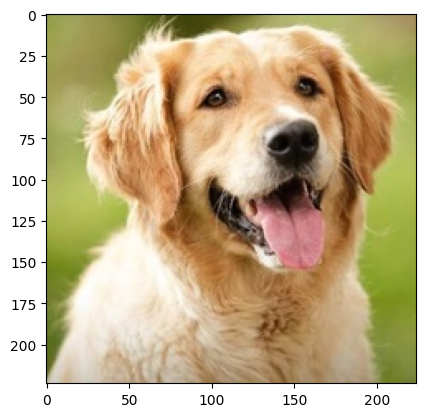

In [9]:
path = "dog1.jpg"
img = Image.open(path)
plt.imshow(img)
X = transforms.ToTensor()(img).to(device).requires_grad_(True)

In [10]:

# Function to replace ReLU with Softplus
def replace_relu_with_softplus(module):
    for name, child in module.named_children():
        if isinstance(child, nn.ReLU):
            setattr(module, name, nn.Softplus(beta=5))
        else:
            replace_relu_with_softplus(child)


In [11]:
cnn = torchvision.models.resnet34().to(device)
cnn_p = torchvision.models.resnet34().to(device)

# Apply the function to the model
replace_relu_with_softplus(cnn_p)

num_features = cnn.fc.in_features
cnn.fc = nn.Linear(num_features, 10, device = device)

num_features = cnn_p.fc.in_features
cnn_p.fc = nn.Linear(num_features, 10, device = device)

cnn.load_state_dict(torch.load("./animals-resnet34-29.pth"))
cnn_p.load_state_dict(torch.load("./animals-resnet34-29.pth"))

cnn.eval()
cnn_p.eval()

g = SimpleGradient(cnn, img_size=(224,224), device=device)
ig = IntegratedGradient(cnn, img_size=(224,224), device=device)

attacker = Attacker(img_size=(224,224), device=device)


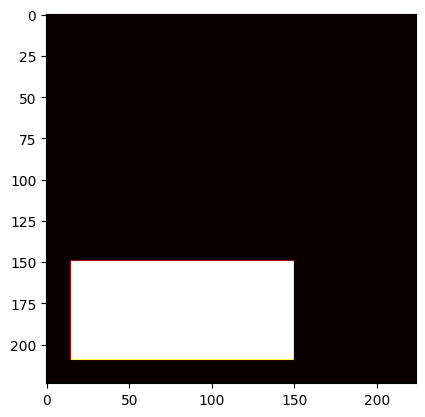

In [12]:
target = torch.zeros((1,224,224), device=device)
target[0,150:210,15:150] += 1.0
# target[0,15:90,10:50] += 0.9
# target[0,155:205,155:205] += 0.75

plt.imshow(target.permute([1,2,0]).to('cpu'), cmap='hot')

In [13]:
X_p_g_1 = attacker.iterative_attack(X, model = cnn, model_p=cnn_p, explainer=g, num_steps = 150, alpha = 0.002, epsilon=0.03, mode = 'target', target = target)
X_p_g_2 = attacker.iterative_attack(X, model = cnn, model_p=cnn_p, explainer=g, num_steps = 150, alpha = 0.002, epsilon=0.03, mode = 'random')

Iteration 0 is running


<ipython-input-5-acc1a5bc07ab>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(model.forward(img))
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


LOSS: tensor([-0.0349], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 1 is running
LOSS: tensor([0.0061], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 2 is running
LOSS: tensor([0.0532], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 3 is running
LOSS: tensor([0.0987], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 4 is running
LOSS: tensor([0.1401], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 5 is running
LOSS: tensor([0.1725], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 6 is running
LOSS: tensor([0.1929], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 7 is running
LOSS: tensor([0.2079], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 8 is running
LOSS: tensor([0.2410], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 9 is running
LOSS: tensor([0.2416], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 10 is running
LOSS: tensor([0.2750], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 11 is running
LOSS: tensor([0.2751], device='cuda:0', 

In [14]:
real_y_pred = torch.argmax(cnn.forward(X.unsqueeze(0)))
manipulated_y_pred_1 = torch.argmax(cnn.forward(X_p_g_1))
manipulated_y_pred_2 = torch.argmax(cnn.forward(X_p_g_2))

print("ORIGIN PRED:", animals_dict[real_y_pred.item()])
print("RANDOM ATTACKED PRED:", animals_dict[manipulated_y_pred_1.item()])
print("TARGET ATTACKED PRED:", animals_dict[manipulated_y_pred_2.item()])

ORIGIN PRED: dog
RANDOM ATTACKED PRED: dog
TARGET ATTACKED PRED: dog


In [15]:
origin_img = X.permute([1,2,0]).detach().to('cpu')
manipulated_img_1 = X_p_g_1.squeeze().permute([1,2,0]).detach().to('cpu')
manipulated_img_2 = X_p_g_2.squeeze().permute([1,2,0]).detach().to('cpu')

g_real_saliency = g.explain(X,real_y_pred).squeeze().detach().to('cpu')
g_manipulated_saliency_1 = g.explain(X_p_g_1,real_y_pred, model = cnn).squeeze().detach().to('cpu')
g_manipulated_saliency_2 = g.explain(X_p_g_2,real_y_pred, model = cnn).squeeze().detach().to('cpu')


print()

<ipython-input-5-acc1a5bc07ab>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(model.forward(img))


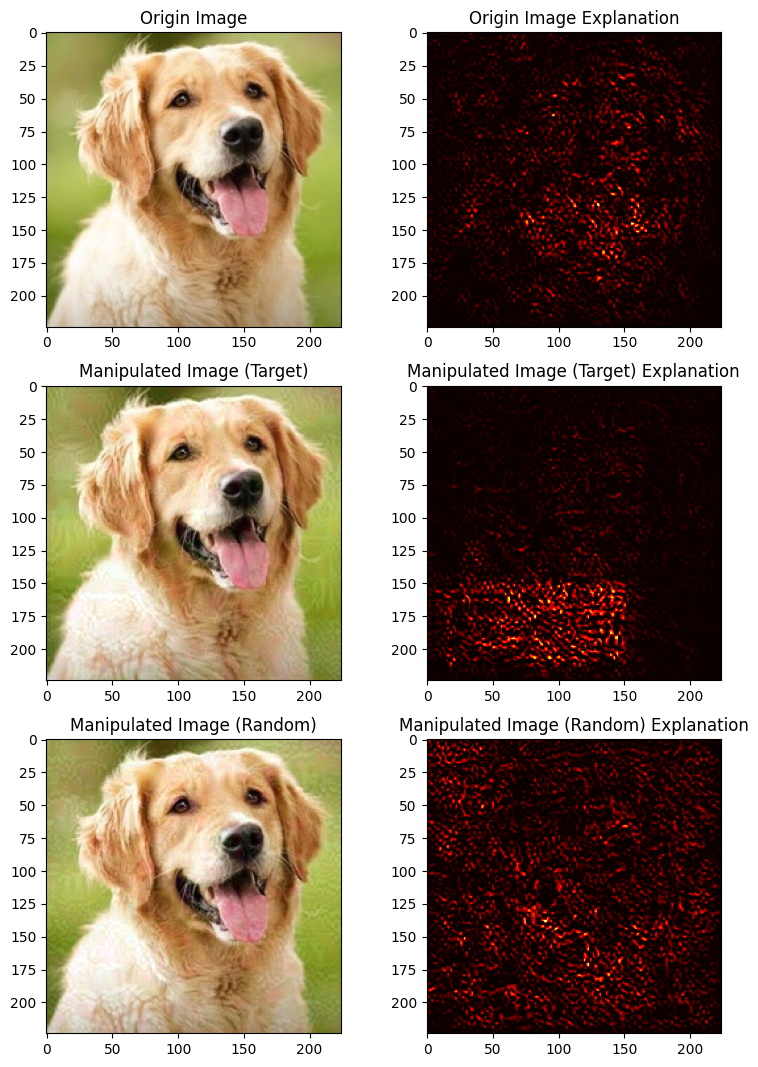

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(9, 13))

axs[0, 0].imshow(origin_img, cmap = 'hot')
axs[0, 0].set_title('Origin Image')
axs[0, 1].imshow(g_real_saliency, cmap = 'hot')
axs[0, 1].set_title('Origin Image Explanation')
axs[1, 0].imshow(manipulated_img_1, cmap = 'hot')
axs[1, 0].set_title('Manipulated Image (Target)')
axs[1, 1].imshow(g_manipulated_saliency_1, cmap = 'hot')
axs[1, 1].set_title('Manipulated Image (Target) Explanation')
axs[2, 0].imshow(manipulated_img_2, cmap = 'hot')
axs[2, 0].set_title('Manipulated Image (Random)')
axs[2, 1].imshow(g_manipulated_saliency_2, cmap = 'hot')
axs[2, 1].set_title('Manipulated Image (Random) Explanation')

plt.show()

In [17]:
X_p_ig_1 = attacker.iterative_attack(X, model = cnn, model_p=cnn_p, explainer=ig, num_steps = 150, alpha = 0.0025, epsilon=0.03, mode = 'target', target = target)
X_p_ig_2 = attacker.iterative_attack(X, model = cnn, model_p=cnn_p, explainer=ig, num_steps = 150, alpha = 0.0025, epsilon=0.03, mode = 'random')

Iteration 0 is running


<ipython-input-6-dc0c176f639a>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(model.forward(x_ig))


LOSS: tensor([-0.0828], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 1 is running
LOSS: tensor([-0.0660], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 2 is running
LOSS: tensor([-0.0451], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 3 is running
LOSS: tensor([-0.0128], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 4 is running
LOSS: tensor([0.0228], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 5 is running
LOSS: tensor([0.0628], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 6 is running
LOSS: tensor([0.1028], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 7 is running
LOSS: tensor([0.1403], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 8 is running
LOSS: tensor([0.1781], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 9 is running
LOSS: tensor([0.2105], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 10 is running
LOSS: tensor([0.2392], device='cuda:0', grad_fn=<SumBackward1>)
Iteration 11 is running
LOSS: tensor([0.2604], device='cuda:0

In [18]:
real_y_pred = torch.argmax(cnn.forward(X.unsqueeze(0)))
manipulated_y_pred_1 = torch.argmax(cnn.forward(X_p_ig_1))
manipulated_y_pred_2 = torch.argmax(cnn.forward(X_p_ig_2))

print("ORIGIN PRED:", animals_dict[real_y_pred.item()])
print("RANDOM ATTACKED PRED:", animals_dict[manipulated_y_pred_1.item()])
print("TARGET ATTACKED PRED:", animals_dict[manipulated_y_pred_2.item()])

ORIGIN PRED: dog
RANDOM ATTACKED PRED: dog
TARGET ATTACKED PRED: dog


In [19]:
origin_img = X.permute([1,2,0]).detach().to('cpu')
manipulated_img_1 = X_p_ig_1.squeeze().permute([1,2,0]).detach().to('cpu')
manipulated_img_2 = X_p_ig_2.squeeze().permute([1,2,0]).detach().to('cpu')

g_real_saliency = ig.explain(X,real_y_pred).squeeze().detach().to('cpu')
g_manipulated_saliency_1 = ig.explain(X_p_ig_1,real_y_pred, model = cnn).squeeze().detach().to('cpu')
g_manipulated_saliency_2 = ig.explain(X_p_ig_2,real_y_pred, model = cnn).squeeze().detach().to('cpu')


print()

<ipython-input-6-dc0c176f639a>:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = F.softmax(model.forward(x_ig))


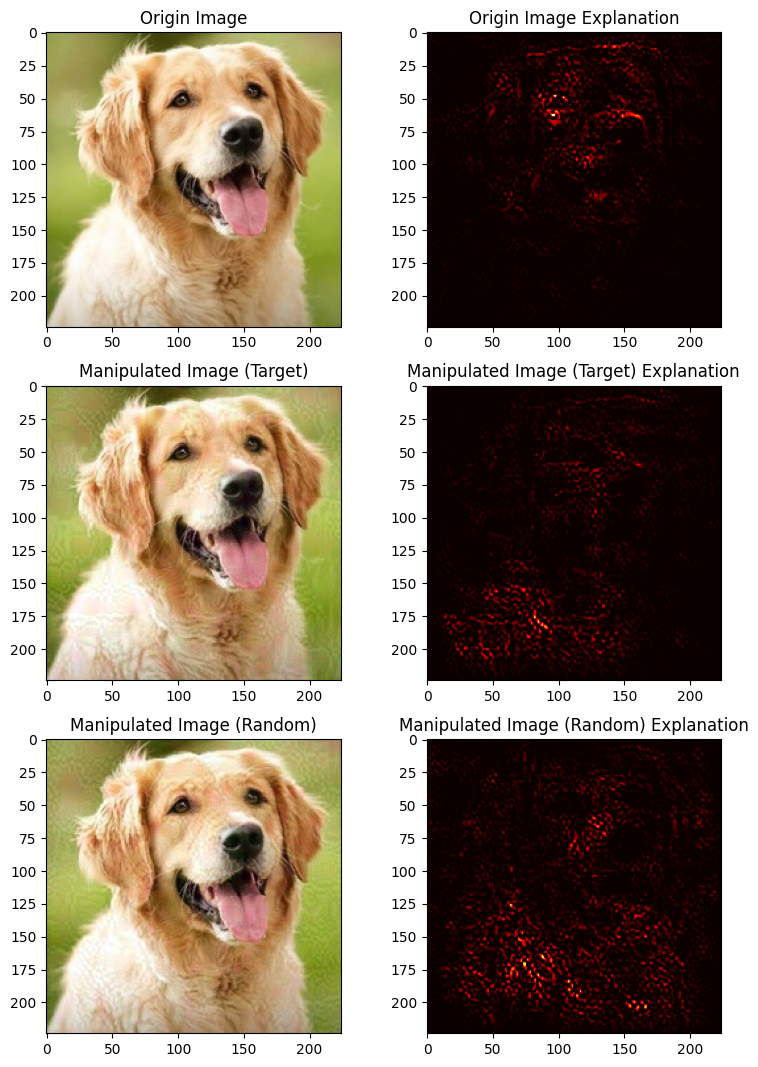

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(9, 13))

axs[0, 0].imshow(origin_img, cmap = 'hot')
axs[0, 0].set_title('Origin Image')
axs[0, 1].imshow(g_real_saliency, cmap = 'hot')
axs[0, 1].set_title('Origin Image Explanation')
axs[1, 0].imshow(manipulated_img_1, cmap = 'hot')
axs[1, 0].set_title('Manipulated Image (Target)')
axs[1, 1].imshow(g_manipulated_saliency_1, cmap = 'hot')
axs[1, 1].set_title('Manipulated Image (Target) Explanation')
axs[2, 0].imshow(manipulated_img_2, cmap = 'hot')
axs[2, 0].set_title('Manipulated Image (Random)')
axs[2, 1].imshow(g_manipulated_saliency_2, cmap = 'hot')
axs[2, 1].set_title('Manipulated Image (Random) Explanation')

plt.show()